## DM2 DMC | Facebook Prophet Baselines: A Single Model for each Item

Let's just use the sales numbers of each single item to produce a very basic forecast.

### Imports

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import logging
import csv
import pickle

from scipy.stats.mstats import zscore

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

### Settings

In [3]:
read_write_prophet_forecasts = 'w'

In [4]:
read_write_prophet_fitted_models = 'w'

### Directories

In [5]:
input_file_sales = 'C:/Users/JulianWeller/Desktop/2018_04_23_a_DM2_DMC_FB_Prophet_Date_Item.xlsx'

In [6]:
data = 'C:/Users/JulianWeller/Desktop/data_v0.5.csv'

In [7]:
test_data_directory = 'C:/Users/JulianWeller/OneDrive - Julian Weller/01_MMDS/03_Semester/04_A_6_Data Mining II/03_DMC/02_Test_Data/DMC_2018_test/'

In [8]:
dump_directory = 'C:/Users/JulianWeller/Desktop/DM2_DMC_Working_Directory/'

### Loading the Data

In [9]:
df = pd.read_excel(input_file_sales)

In [10]:
df_prices = pd.read_csv(data)

In [11]:
df_prices.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
df_prices.head()

,key,pid,size,color,brand,rrp,mainCategory,category,subCategory,stock,...,2018-02-28_prices_normalized_lag_19,2018-02-28_prices_normalized_lag_20,2018-02-28_prices_normalized_lag_21,2018-02-28_prices_normalized_lag_22,2018-02-28_prices_normalized_lag_23,2018-02-28_prices_normalized_lag_24,2018-02-28_prices_normalized_lag_25,2018-02-28_prices_normalized_lag_26,2018-02-28_prices_normalized_lag_27,2018-02-28_prices_normalized_lag_28
0,10000XL ( 158-170 ),10000.0,XL ( 158-170 ),gruen,Nike,25.33,1.0,7.0,25.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10001L,10001.0,L,schwarz,Jako,38.03,1.0,7.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100033 (35-38 ),10003.0,3 (35-38 ),weiss,Jako,12.63,1.0,7.0,13.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100034 ( 39-42 ),10003.0,4 ( 39-42 ),weiss,Jako,12.63,1.0,7.0,13.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100035 ( 43-46 ),10003.0,5 ( 43-46 ),weiss,Jako,12.63,1.0,7.0,13.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's split into train and test data (test data is not used, as there is test data provided by the chair):

In [13]:
df_train = df.drop(df.tail(31).index)

In [14]:
df_train.tail()

,ds,10000XL ( 158-170 ),10001L,100033 (35-38 ),100034 ( 39-42 ),100035 ( 43-46 ),10006XL,10008XL,10013L,10013M,...,2286946,2286947,"2286947,5",22872M ( 140-152 ),22873L,228782XL,22878L,22878M,22878XL,22881S
87,2017-12-27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
88,2017-12-28,0,0,0,0,0,0,0,0,0,...,0,0,10,0,0,10,30,10,20,0
89,2017-12-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90,2017-12-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,2017-12-31,0,0,0,0,0,0,0,0,0,...,0,0,0,30,0,0,0,0,0,10


Not used, but here's the January data:

In [15]:
df_test = df.drop(df.head(92).index)

In [16]:
df_test.head()

,ds,10000XL ( 158-170 ),10001L,100033 (35-38 ),100034 ( 39-42 ),100035 ( 43-46 ),10006XL,10008XL,10013L,10013M,...,2286946,2286947,"2286947,5",22872M ( 140-152 ),22873L,228782XL,22878L,22878M,22878XL,22881S
92,2018-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,0,0
93,2018-01-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0,0,0,10
94,2018-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,2018-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,2018-01-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's create that 'ds' column FB prophet always needs:

In [17]:
df_ds = df_train.iloc[:,[0]]

In [18]:
df_ds.head()

,ds
0,2017-10-01
1,2017-10-02
2,2017-10-03
3,2017-10-04
4,2017-10-05


Let's create a list of dataframes where each such dataframe contains a 'ds' and a 'y' column so that we can easily give it to the prophet and ask for predictions:

In [19]:
list_of_dataframes = []

And let's keep track of the item keys:

In [20]:
list_of_item_keys = []

In [21]:
for i in range(1, 12825):
    df_to_be_appended = df_ds.join(df_train.iloc[:,[i]])
    
    list_of_item_keys.append(df_to_be_appended.columns[1])
    
    df_to_be_appended.columns = ['ds', 'y']
    
    list_of_dataframes.append(df_to_be_appended)

Here's an example of a list entry:

In [22]:
list_of_item_keys[0]

'10000XL ( 158-170 )'

In [23]:
list_of_dataframes[6].head()

,ds,y
0,2017-10-01,0
1,2017-10-02,0
2,2017-10-03,0
3,2017-10-04,0
4,2017-10-05,0


Let's get the normalized prices so that we can add them as an additional regressor:

In [24]:
date_price_list_train = [i + "_prices_normalized" for i in df_ds['ds'].tolist()]

In [25]:
date_price_list_test = [i + "_prices_normalized" for i in df_test.iloc[:,[0]]['ds'].tolist()]

In [26]:
lists_of_prices_per_item_train = []

In [27]:
lists_of_prices_per_item_test = []

In [28]:
for item_key in list_of_item_keys:
    price_list_train = []
    price_list_test = []
    
    bool_error = False
    
    for price_date_train in date_price_list_train:
        try:
            price_list_train.append(df_prices.loc[df_prices['key'] == item_key].iloc[0][price_date_train])
        except:
            bool_error = True
            price_list_train.append(np.nan)
        
    for price_date_test in date_price_list_test:
        try:
            price_list_test.append(df_prices.loc[df_prices['key'] == item_key].iloc[0][price_date_test])
        except:
            bool_error = True
            price_list_test.append(np.nan)
        
    if not bool_error:
        lists_of_prices_per_item_train.append(price_list_train)
        lists_of_prices_per_item_test.append(price_list_test)
    else:
        lists_of_prices_per_item_train.append(np.nan)
        lists_of_prices_per_item_test.append(np.nan)

In [29]:
for idx, val in enumerate(list_of_dataframes):
    if not str(lists_of_prices_per_item_train[idx]) == str(np.nan):
        val['prices_normalized'] = lists_of_prices_per_item_train[idx]

Marketing activities as provided by Basil:

In [30]:
################################
# Taken from Basil: datamining2/data/datasets_Basil/create_dataset_v0.3.ipynb
#creating array with dates where 11 Teamsports announces discount on social media
marketingactivities=['2017-10-11','2017-10-16','2017-11-04','2017-11-11','2017-11-23','2017-11-24',
                     '2017-11-25','2017-11-27','2017-12-03','2017-12-27','2017-12-28','2017-12-31',
                    '2018-01-14','2018-01-22','2018-01-23','2018-01-30','2018-02-06','2018-02-07',
                     '2018-02-20','2018-02-22','2018-02-23']
################################

In [31]:
marketingactivities_prophet = pd.DataFrame({
    'holiday': 'marketingactivity',
    'ds': pd.to_datetime(marketingactivities),
    })

The prophet may shut up while propheting:

In [32]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

A list with the prophet's fitted models:

In [33]:
prophet_fitted_models = []

In [34]:
if read_write_prophet_fitted_models == 'w':
    for idx, val in enumerate(list_of_dataframes):
        if not str(lists_of_prices_per_item_train[idx]) == str(np.nan):
            try:
                prophet_fitted_models.append(Prophet(holidays = marketingactivities_prophet).add_regressor('prices_normalized').fit(val))
            except:
                # If prices are constant, Prophet will throw an error
                prophet_fitted_models.append(Prophet(holidays = marketingactivities_prophet).fit(val))

C:\Users\JulianWeller\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [35]:
if read_write_prophet_fitted_models == 'w':
    with open(dump_directory + "prophet_fitted_models_v2", "wb") as fp:
        pickle.dump(prophet_fitted_models, fp)

In [36]:
if read_write_prophet_fitted_models == 'r':
    with open(dump_directory + "prophet_fitted_models_v2", "rb") as fp:
        prophet_fitted_models = pickle.load(fp)

And another one with the prophet's forecasts:

In [37]:
prophet_forecasts = []

In [38]:
if read_write_prophet_forecasts == 'w':
    for idx, val in enumerate(prophet_fitted_models):
        future = val.make_future_dataframe(periods=31)[92:]
        
        if not str(lists_of_prices_per_item_test[idx]) == str(np.nan):
            future['_prices_normalized'] = lists_of_prices_per_item_test[idx]

        prophet_forecasts.append(val.predict(future)[['ds', 'yhat']])

In [39]:
if read_write_prophet_forecasts == 'w':
    with open(dump_directory + "prophet_forecasts_v2", "wb") as fp:
        pickle.dump(prophet_forecasts, fp)

In [40]:
if read_write_prophet_forecasts == 'r':
    with open(dump_directory + "prophet_forecasts_v2", "rb") as fp:
        prophet_forecasts = pickle.load(fp)

Let's look at an example:

In [41]:
list_of_item_keys[6]

'10008XL'

In [42]:
prophet_forecasts[6].head()

,ds,yhat
0,2018-01-01,0.838017
1,2018-01-02,0.048817
2,2018-01-03,0.071798
3,2018-01-04,0.840025
4,2018-01-05,0.062056


### Adjust Predictions for Items

Count how often an item was sold overall:

In [43]:
list_of_column_names_of_items = df_train.columns.tolist()[1:]

In [44]:
list_of_column_names_of_items[0]

'10000XL ( 158-170 )'

In [45]:
list_of_column_names_of_items[-1]

'22881S'

In [46]:
df_train_sums = [df_train[i].sum() for i in list_of_column_names_of_items]

In [47]:
pd.DataFrame(df_train_sums).describe()

,0
count,12824.000000
mean,177.826731
std,680.618204
min,0.000000
25%,10.000000
50%,40.000000
75%,110.000000
max,19960.000000


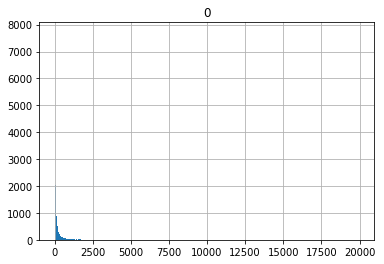

In [48]:
plt.show(pd.DataFrame(df_train_sums).hist(bins=len(set(df_train_sums))))

In [49]:
len(df_train_sums)

12824

Count for each item the number of days on which it was sold (at least once):

In [50]:
df_train_cnt_non_zero = df_train.astype(bool).sum(axis=0)[1:]

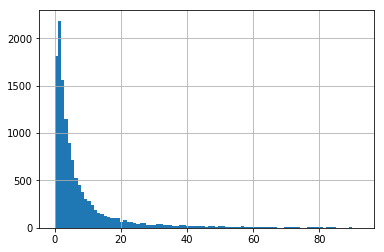

In [51]:
plt.show(df_train_cnt_non_zero.hist(bins=len(set(df_train_cnt_non_zero.tolist()))))

In [52]:
df_train_cnt_non_zero.describe()

count    12824.000000
mean         7.716079
std         12.441867
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max         92.000000
dtype: float64

In [53]:
df_train_cnt_non_zero = df_train_cnt_non_zero.tolist()

In [54]:
len(df_train_cnt_non_zero)

12824

### Loading the Test Data from the Chair

In [55]:
test_data = []

In [56]:
for i in range(0, 5):
    df = pd.read_csv(test_data_directory + 'test_' + str(i) + '.csv', dtype={'pid': int})
    
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    ################################
    # Taken from Basil: datamining2/data/datasets_Basil/create_dataset_v0.3.ipynb
    #Creating key for train dataset
    keys3=[]
    i=0
    while i<len(df):
        key=str(df.iloc[i,0]) + str(df.iloc[i,1])
        keys3.append(key)
        i=i+1
        
    df['key']=keys3
    ################################
    
    df.drop(df.columns[0], axis=1, inplace=True)
    df.drop(df.columns[0], axis=1, inplace=True)
    
    df['soldout_day'] = df['sold_out_date'].str[-2:]
    
    df.soldout_day = pd.to_numeric(df.soldout_day, errors='coerce')
    
    df.drop(df.columns[1], axis=1, inplace=True)
    
    test_data.append(df)

In [57]:
test_data[0].head()

,stock,key,soldout_day
0,1.0,10001L,7
1,1.0,100035 ( 43-46 ),30
2,4.0,10008XL,30
3,1.0,10013L,24
4,1.0,10013M,22


Here's an example of how the data in the dataframes can be accessed:

In [58]:
list_of_item_keys[6]

'10008XL'

In [59]:
test_data[0].loc[df['key'] == list_of_item_keys[6]].iloc[0]['stock']

4.0

In [60]:
test_data[0].loc[df['key'] == list_of_item_keys[6]].iloc[0]['soldout_day']

30

### Evaluation

In [383]:
################################
# Taken from Chung: datamining2/measures/objectives.py
def soldout_day(pred, stock):
    """
    Calculates first day that stock hits 0 in a certain month for an item
    :param pred: Array of predicted sales units for an item
    :param stock: Stock at beginning of month for an item
    :return: Day of month that stock reaches 0
    """
    soldout_day = len(pred)
    for day in range(len(pred)):
        stock -= pred[day]
        #print(stock)
        if stock <= 0:
            soldout_day = day+1
            break
    return soldout_day
################################

In [384]:
prophet_forecasts_sold_out_days = []

In [385]:
test_data_sold_out_days = []

In [386]:
list_of_item_keys_test = []

What about validation data for deciding on the hyperparameter values? Not really feasible here, I guess.

In [387]:
for j in test_data:
    
    j_key_set = set(j['key'].tolist())
    
    prophet_forecasts_sold_out_days_test = []
    test_data_sold_out_days_test = []
    list_of_item_keys_test_test = []
    
    for idx, val in enumerate(prophet_forecasts):
        item_key = list_of_item_keys[idx]
        if item_key in j_key_set:
            
            # Only use predictions for items that were sold on at least xxx days etc., otherwise predict the middle of the month (Jan 17)
            if df_train_cnt_non_zero[idx] >= 70 and df_train_sums[idx] >= 70 and df_train_sums[idx] <= 1000:
                soldout_day_to_be_appended = soldout_day(val['yhat'].tolist(), j.loc[df['key'] == item_key].iloc[0]['stock'])
            else:
                soldout_day_to_be_appended = 17
                           
            #soldout_day_to_be_appended = soldout_day(val['yhat'].tolist(), j.loc[df['key'] == item_key].iloc[0]['stock'])
            
            prophet_forecasts_sold_out_days_test.append(soldout_day_to_be_appended)
            test_data_sold_out_days_test.append(j.loc[df['key'] == item_key].iloc[0]['soldout_day'])
            list_of_item_keys_test_test.append(item_key)
                             
    prophet_forecasts_sold_out_days.append(prophet_forecasts_sold_out_days_test)
    test_data_sold_out_days.append(test_data_sold_out_days_test)
    list_of_item_keys_test.append(list_of_item_keys_test_test)

Z-Score normalization of predictions:

In [388]:
# prophet_forecasts_sold_out_days = [zscore(i) for i in prophet_forecasts_sold_out_days]

Scale to [1, 31]:

In [389]:
# prophet_forecasts_sold_out_days_normalized = []

# for i in prophet_forecasts_sold_out_days:
#     temp = []
#     temp_min = min(i)
#     temp_max = max(i)
#     for j in i:
#         temp.append(1 + int(round(30*((j-temp_min)/(temp_max-temp_min)))))
#     prophet_forecasts_sold_out_days_normalized.append(temp)

In [390]:
# prophet_forecasts_sold_out_days = prophet_forecasts_sold_out_days_normalized

In [391]:
# min(prophet_forecasts_sold_out_days[0])

In [392]:
# max(prophet_forecasts_sold_out_days[0])

Here's some explanation:

These lengths are five, because there are five test sets:

In [393]:
len(prophet_forecasts_sold_out_days)

5

In [394]:
len(test_data_sold_out_days)

5

In [395]:
len(list_of_item_keys_test)

5

These lengths are 8142, because that's the number of items included in the test data provided by the chair. There are five of them, because there are five test sets.

In [396]:
print([len(i) for i in prophet_forecasts_sold_out_days])

[8138, 8138, 8138, 8138, 8138]


In [397]:
print([len(i) for i in test_data_sold_out_days])

[8138, 8138, 8138, 8138, 8138]


In [398]:
print([len(i) for i in list_of_item_keys_test])

[8138, 8138, 8138, 8138, 8138]


Let's calculate the square root of the sum of absolute deviations of predicted sold-out-day and true sold-out-day for all the 8142 items for each of the test sets:

In [399]:
sqrt_sum_abs_difference_sold_out_days = []

In [400]:
for pred, true in zip(prophet_forecasts_sold_out_days, test_data_sold_out_days):
    # Credits to Chung for the abs_sales_diff function from which I borrow here
    sqrt_sum_abs_difference_sold_out_days.append(np.sqrt(sum([abs(pred[i] - true[i]) for i in range(len(pred))])))

Here we have the test scores for each of the five test sets:

In [401]:
sqrt_sum_abs_difference_sold_out_days

[259.1833327974621,
 259.47832279402456,
 259.82301668635904,
 259.5052985971577,
 259.33954576963384]

And as asked for, the average and the standard deviation:

In [402]:
np.average(sqrt_sum_abs_difference_sold_out_days)

259.4659033289274

In [403]:
np.std(sqrt_sum_abs_difference_sold_out_days)

0.2121549049027748

### Analysis of Results

Let's have a closer look at the results for the items for each of the test sets:

In [404]:
list_of_dfs_of_evaluation_results_for_test_sets = []

In [405]:
for i in range(0, 5):
    df_to_be_appended = pd.DataFrame({'key': list_of_item_keys_test[i], 'pred': prophet_forecasts_sold_out_days[i], 'true': test_data_sold_out_days[i]})
    
    df_to_be_appended['abs_dev'] = abs(df_to_be_appended['pred'] - df_to_be_appended['true'])
    
    list_of_dfs_of_evaluation_results_for_test_sets.append(df_to_be_appended)

In [406]:
list_of_dfs_of_evaluation_results_for_test_sets[0].head()

,key,pred,true,abs_dev
0,10001L,17,7,10
1,100035 ( 43-46 ),17,30,13
2,10008XL,17,30,13
3,10013L,17,24,7
4,10013M,17,22,5


In [407]:
list_of_dfs_of_evaluation_results_for_test_sets[0].describe()

,pred,true,abs_dev
count,8138.0,8138.000000,8138.000000
mean,17.0,16.987466,8.254608
std,0.0,9.511419,4.724439
min,17.0,1.000000,0.000000
25%,17.0,9.000000,4.000000
50%,17.0,17.000000,8.000000
75%,17.0,25.000000,13.000000
max,17.0,31.000000,16.000000


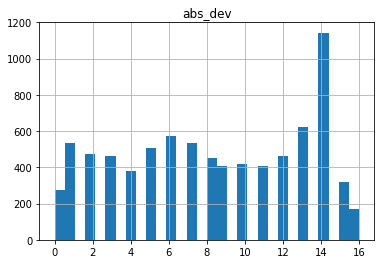

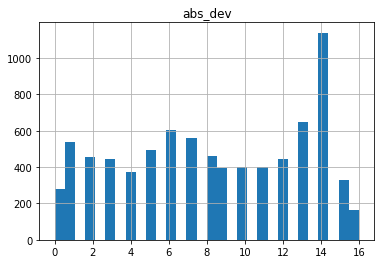

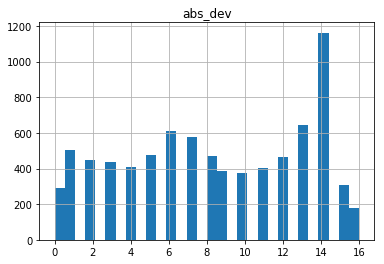

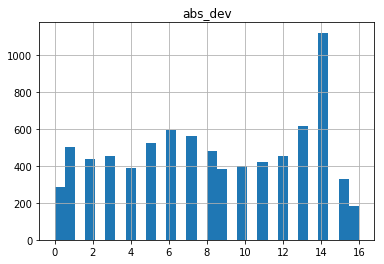

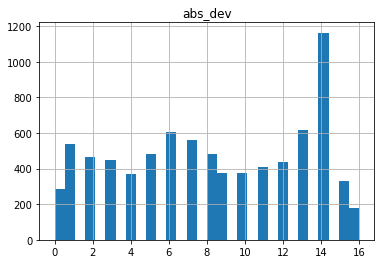

In [408]:
for i in list_of_dfs_of_evaluation_results_for_test_sets:
    plt.show(i.hist(column='abs_dev', bins=30))